implementation of [universal style transfer via feature transforms by Li et al](https://arxiv.org/pdf/1705.08086.pdf)

In [1]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# make variables display whenever they are on their own line (not just the last line of a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [70]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import skimage.transform

from utils import *

## Settings

In [5]:
layer = 'conv4'

## Featureize images

In [ ]:
compute_features('D:/test2017', out_layer_name='vgg_19/' + layer + '/' + layer + '_1', num_images=20000)
compute_features('D:/val2017', out_layer_name='vgg_19/' + layer + '/' + layer + '_1', num_images=200)

## Create graph

In [6]:
layer_to_sizes = {
    'conv1': (None, 224, 224, 64),
    'conv2': (None, 112, 112, 128),
    'conv4': (None, 28, 28, 512)
}

tf.reset_default_graph()
sess = tf.Session()
images_ph = tf.placeholder('float', (None, 224, 224, 3), name='images')
features_ph = tf.placeholder('float', layer_to_sizes[layer], name='features')

In [7]:
train_dataset = make_precomputed_dataset('D:/test2017', layer, num_images=20000, batch_size=32)
val_dataset = make_precomputed_dataset('D:/val2017', layer, num_images=200, batch_size=32)

In [8]:
architecture_4 = [(3, 256), 'upsample', (3, 256), (3, 256), (3, 256), (3, 128), 'upsample', (3, 112), (3, 64), 'upsample', (3, 64), (3, 3)]
architecture_1 = [(3, 3)]
reconstructed_image, regularized = make_decoder(features_ph, architecture_4, sess)
(per_img_loss, total_loss) = create_loss(images_ph, features_ph, 
                                         reconstructed_image, 'vgg_19/' + layer + '/' + layer + '_1', 
                                         regularized, sess, lambda_reg=1e-3)

INFO:tensorflow:Restoring parameters from vgg_19.ckpt


In [9]:
(train_step, merged) = setup_training(total_loss, train_dataset, sess, lr=5e-5)

[<tf.Variable 'decoder/conv_layer_0/filters:0' shape=(3, 3, 512, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_0/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_2/filters:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_2/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_3/filters:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_3/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_4/filters:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_4/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_5/filters:0' shape=(3, 3, 256, 128) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_5/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_7/filters:0' shape=(3, 3, 128, 112) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_7/biases:0' shape=(112,) dtype=float32_ref

In [10]:
train(per_img_loss, train_step, merged, train_dataset, val_dataset, images_ph, features_ph, sess,
      num_epochs=5, summary_freq=50)

initial validation loss 1014533.1
training loss 1025720.25
training loss 799440.2
training loss 755060.25
training loss 715735.5
training loss 670768.06
training loss 653998.0
training loss 609963.25
training loss 594906.06
training loss 571237.6
training loss 466561.94
training loss 413575.6
training loss 334572.2
training loss 296446.25
validation loss after epoch 0 is 321390.045
training loss 280213.06
training loss 279257.47
training loss 256075.03
training loss 244853.83
training loss 224966.44
training loss 227815.72
training loss 199723.72
training loss 206560.47
training loss 224496.06
training loss 197796.88
training loss 208210.78
training loss 179484.9
validation loss after epoch 1 is 200374.35
training loss 179507.48
training loss 175372.05
training loss 202979.61
training loss 163832.12
training loss 182435.66
training loss 174664.83
training loss 173730.39
training loss 154973.5
training loss 188558.19
training loss 163232.28
training loss 170064.89
training loss 180712.6

In [11]:
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'decoder'))
saver.save(sess, './decoder4/decoder')

'./decoder4/decoder'

## testing

In [ ]:
derp_dataset = make_precomputed_dataset('../val2017', 'conv4', num_images=50)
it = derp_dataset.make_one_shot_iterator()
next_elem = it.get_next()

In [ ]:
img = sess.run(it.get_next())[0]
img = img[np.newaxis,:,:,:]

In [12]:
# img2 = imread('../val2017/000000000139.jpg', pilmode='RGB')
img2 = imread('C:/users/rtimpe/downloads/cat.jpg')
img2 = skimage.transform.resize(img2, (224, 224, 3))
img2 *= 255
# np.square(img - img2).sum()

C:\Anaconda\envs\style\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
plt.imshow(np.squeeze(img).astype(np.uint8))
plt.show()
plt.imshow(img2.astype(np.uint8))

In [13]:
encoded_img = encode_image(img2[np.newaxis, :,:,:], 'vgg_19/' + layer + '/' + layer + '_1')
reconstructed = sess.run(reconstructed_image, feed_dict={features_ph: encoded_img})
reconstructed = np.squeeze(reconstructed)

INFO:tensorflow:Restoring parameters from vgg_19.ckpt


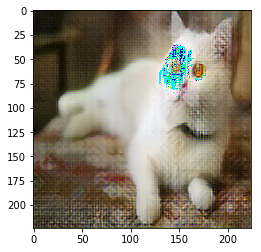

In [14]:
plt.imshow((reconstructed).astype(np.uint8))

In [ ]:
plt.imshow(np.squeeze(img2).astype(np.uint8))


## style transfer stuff

In [60]:
# img = imread('../val2017/000000000139.jpg', pilmode='RGB')
img = imread('C:/users/rtimpe/downloads/starry.jpeg')
img = skimage.transform.resize(img, (224, 224, 3))
img = img[np.newaxis, :, :, :]
img = img * 255
encoded_img = encode_image(img, 'vgg_19/' + layer + '/' + layer + '_1')
img.max()


C:\Anaconda\envs\style\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


INFO:tensorflow:Restoring parameters from vgg_19.ckpt


255.0

In [61]:
v = encoded_img.reshape(-1, encoded_img.shape[2]).T
v_centered = v - np.mean(v)
w, _ = whiten(v_centered)
w = np.reshape(w, (1, 28, 28, 512)) + v.mean()

In [65]:
alpha = .2
interp = alpha * encoded_img + (1.0 - alpha) * w

In [66]:
reconstructed = sess.run(reconstructed_image, feed_dict={features_ph: interp})
reconstructed = np.squeeze(reconstructed)

In [43]:
(reconstructed).max()

221.64296

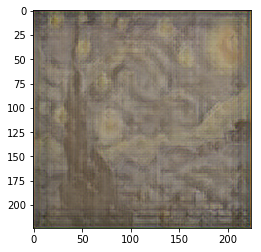

In [67]:
# plt.imshow(((reconstructed[:,:,[2,1,0]])).astype(np.uint8))
# plt.show()
plt.imshow(((reconstructed * 1)).astype(np.uint8))

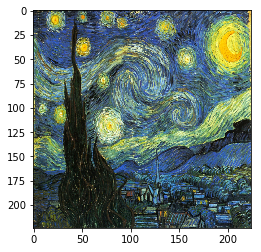

In [68]:
plt.imshow(np.squeeze(img.astype(np.uint8)))

In [75]:
content = encode_file('C:/users/rtimpe/downloads/cat.jpg', layer)
style = encode_file('C:/users/rtimpe/downloads/starry.jpeg', layer)

C:\Anaconda\envs\style\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


INFO:tensorflow:Restoring parameters from vgg_19.ckpt
INFO:tensorflow:Restoring parameters from vgg_19.ckpt


In [83]:
v = content.reshape(-1, content.shape[2]).T
v_centered = v - np.mean(v)
w, _ = whiten(v_centered)
# w = np.reshape(w, (1, 28, 28, 512))
style_r = style.reshape(-1, style.shape[2]).T
cs,_ = color(w, style_r)
cs = cs + style.mean()
cs = np.reshape(cs, (1, 28, 28, 512))

In [95]:
alpha = .3
interp = alpha * content + (1.0 - alpha) * cs

In [96]:
reconstructed = sess.run(reconstructed_image, feed_dict={features_ph: interp})
reconstructed = np.squeeze(reconstructed)

C:\Anaconda\envs\style\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


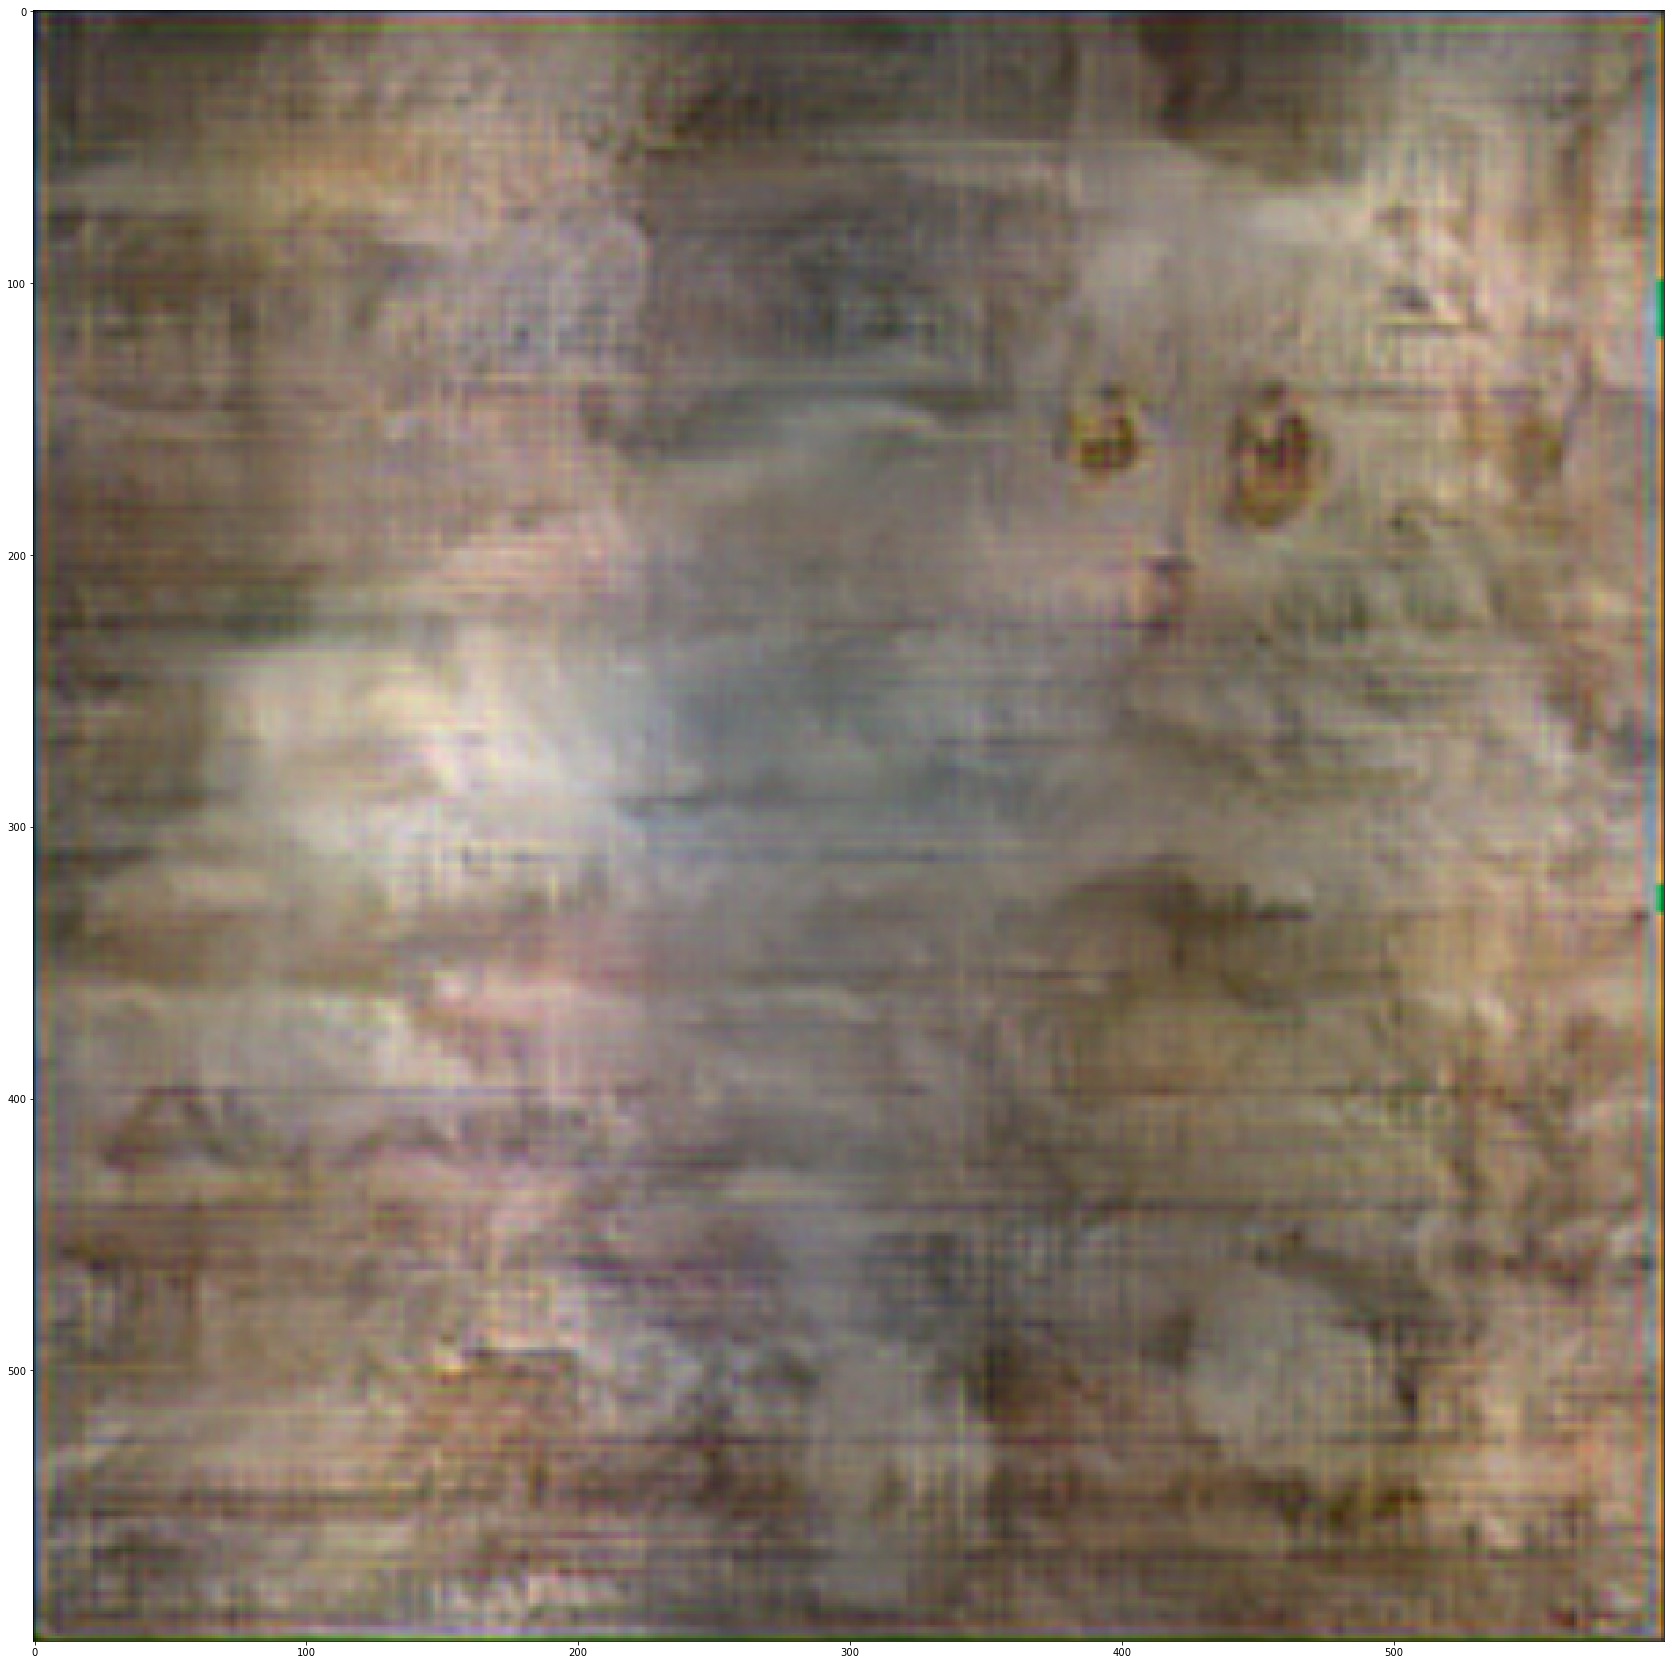

In [106]:
fix, ax = plt.subplots(figsize=(30,30))
ax.imshow(skimage.transform.resize(reconstructed.astype(np.uint8), (600, 600, 3)))

## other crap

In [ ]:
it = dataset.make_one_shot_iterator()

In [ ]:
img,_ = sess.run(it.get_next())
img

In [ ]:
plt.imshow(img)

In [ ]:
decoded_img = sess.run(reconstructed_image, feed_dict={input_ph: img[np.newaxis,:,:,:]})

In [ ]:
decoded_img = np.squeeze(decoded_img)

In [ ]:
decoded_img[decoded_img > 255] = 255

In [ ]:
plt.imshow(decoded_img.astype(np.uint8))

In [ ]:
writer = tf.summary.FileWriter('summaries', sess.graph)

In [ ]:
sess.run(dataset.make_one_shot_iterator().get_next())

In [ ]:
it = dataset.make_one_shot_iterator()
sess.run(it.get_next())[1].shape

In [ ]:
# make_encoder(images_ph, sess)
writer = tf.summary.FileWriter('summaries', sess.graph)